In [3]:
import os
from shapely.geometry import Polygon

os.environ["USE_PYGEOS"] = "0"
import geopandas
import shutil
import numpy as np
import napari
import os
import spatialdata as sd
from spatialdata.transformations import (
    Affine,
    Sequence,
    Identity,
    align_elements_using_landmarks,
    get_transformation,
    set_transformation,
)
from napari_spatialdata import Interactive

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print("current working directory:", os.getcwd())
SPATIALDATA_SANDBOX_PATH = "spatialdata-sandbox"
assert os.path.isdir(
    SPATIALDATA_SANDBOX_PATH
), f"{SPATIALDATA_SANDBOX_PATH} not found, please use symlinks to make it available"
GENERATED_DATA_PATH = os.path.join(
    SPATIALDATA_SANDBOX_PATH, "generated_data/xenium_visium_integration"
)
assert os.path.isdir(
    GENERATED_DATA_PATH
), f"{GENERATED_DATA_PATH} not found, please use symlinks to make it available"


XE_REP1_PATH = os.path.join(
    SPATIALDATA_SANDBOX_PATH, "xenium_rep1_io/data_aligned.zarr"
)
XE_REP2_PATH = os.path.join(
    SPATIALDATA_SANDBOX_PATH, "xenium_rep2_io/data_aligned.zarr"
)
VISIUM_PATH = os.path.join(
    SPATIALDATA_SANDBOX_PATH, "visium_associated_xenium_io/data_aligned.zarr"
)
# XE_REP1_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep1_io/data.zarr")
# XE_REP2_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep2_io/data.zarr")
# VISIUM_PATH = os.path.join(
#     SPATIALDATA_SANDBOX_PATH, "visium_associated_xenium_io/data.zarr"
# )
assert os.path.isdir(XE_REP1_PATH), XE_REP1_PATH
assert os.path.isdir(XE_REP2_PATH), XE_REP2_PATH
assert os.path.isdir(VISIUM_PATH), VISIUM_PATH

XE_REP1_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep1_roi.zarr")
XE_REP2_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep2_roi.zarr")
VISIUM_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "visium_roi.zarr")

LANDMARKS_SDATA_PATH = os.path.join(GENERATED_DATA_PATH, "sandbox.zarr")

current working directory: /Users/macbook/embl/projects/basel/spatialdata-notebooks/notebooks/paper_reproducibility


In [5]:
# we delete some elements (in-memory only) because we will not need them in napari
xe_rep1_sdata = sd.read_zarr(XE_REP1_PATH)
del xe_rep1_sdata.images["morphology_focus"]
del xe_rep1_sdata.shapes["cell_boundaries"]
del xe_rep1_sdata.shapes["nucleus_boundaries"]
xe_rep2_sdata = sd.read_zarr(XE_REP2_PATH)
del xe_rep2_sdata.images["morphology_focus"]
del xe_rep2_sdata.shapes["cell_boundaries"]
del xe_rep2_sdata.shapes["nucleus_boundaries"]
visium_sdata = sd.read_zarr(VISIUM_PATH)

xe_rep1_roi_sdata = sd.read_zarr(XE_REP1_ROI_PATH)
del xe_rep1_roi_sdata.shapes["cell_boundaries"]
del xe_rep1_roi_sdata.shapes["nucleus_boundaries"]
xe_rep2_roi_sdata = sd.read_zarr(XE_REP2_ROI_PATH)
del xe_rep2_roi_sdata.shapes["cell_boundaries"]
del xe_rep2_roi_sdata.shapes["nucleus_boundaries"]
visium_roi_sdata = sd.read_zarr(VISIUM_ROI_PATH)

landmarks_sdata = sd.read_zarr(LANDMARKS_SDATA_PATH)

INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            


In [6]:
landmarks_sdata["rois"]["name"] = [
    "Invasive",
    "Immune infiltration",
    "DCIS",
    "Necrotic core",
]
# the new extra column gets not saved to Zarr, we need to discuss this behavior (and the relationships with multiple tables) in the next hackathon
landmarks_sdata["rois"]

,geometry,name
0,"POLYGON ((1928.166 9124.230, 1928.166 9151.215...",Invasive
1,"POLYGON ((8109.926 14163.968, 8109.926 14173.7...",Immune infiltration
2,"POLYGON ((32042.805 22387.401, 32026.302 22436...",DCIS
3,"POLYGON ((27504.676 20232.314, 27514.049 20237...",Necrotic core


In [7]:
# remove the cells, for xenium rep 2, inside the box (so already present in xenium rep 1)
xe_rep2_sdata.shapes["cell_circles"] = xe_rep2_sdata["cell_circles"][
    ~xe_rep2_sdata["cell_circles"].index.isin(xe_rep2_roi_sdata["cell_circles"].index)
]

In [8]:
from anndata import AnnData


def set_colors_for_categorical_obs(
    adata: AnnData, column: str, colors_dict: dict[str, str]
):
    colors = []
    for cat in adata.obs[column].cat.categories.tolist():
        color = colors_dict[cat]
        colors.append(color)
    adata.uns[f"{column}_colors"] = colors


celltype_major_colors = {
    "B-cells": "#d8f55e",
    "CAFs": "#532C8A",
    "Cancer Epithelial": "#C72228",
    "Endothelial": "#9e6762",
    "Myeloid": "#ffe012",
    "T-cells": "#3cb44b",
    "Normal Epithelial": "#0F4A9C",
    "PVL": "#c09d9a",
    "Plasmablasts": "#000075",
}
set_colors_for_categorical_obs(
    adata=xe_rep1_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)
set_colors_for_categorical_obs(
    adata=xe_rep2_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)

In [9]:
xe_rep1_roi_sdata.table.obs["celltype_major"] = xe_rep1_roi_sdata.table.obs[
    "celltype_major"
].astype("category")
xe_rep1_roi_sdata.table.obs["celltype_minor"] = xe_rep1_roi_sdata.table.obs[
    "celltype_minor"
].astype("category")
xe_rep2_roi_sdata.table.obs["celltype_major"] = xe_rep2_roi_sdata.table.obs[
    "celltype_major"
].astype("category")
xe_rep2_roi_sdata.table.obs["celltype_minor"] = xe_rep2_roi_sdata.table.obs[
    "celltype_minor"
].astype("category")

set_colors_for_categorical_obs(
    adata=xe_rep1_roi_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)
set_colors_for_categorical_obs(
    adata=xe_rep2_roi_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)

In [10]:
clone_colors = {
    "1": "#DA1F26",
    "2": "#F37F73",
    "3": "#7BB0DF",
    "diploid": "#00000000",
    "not detected": "#00000000",
    # "diploid": "#1966B0",
    # "not detected": "#892F73",
}

set_colors_for_categorical_obs(
    adata=visium_sdata.table,
    column="clone",
    colors_dict=clone_colors,
)

In [20]:
visium_roi_sdata.table.write("/Users/macbook/Desktop/visium_roi_table.h5ad")

In [10]:
from spatialdata import SpatialData
from shapely import Polygon
from spatialdata.models import ShapesModel


# same function of notebooks 00, move to a .py file, later on include a reworked version in spatialdata
def spatial_query_shapes_and_points_by_polygon(
    sdata: SpatialData, polygon: Polygon, target_coordinate_system: str
):
    new_shapes = {}
    for shapes_name, shapes in sdata.shapes.items():
        if "__old_index" in shapes.columns:
            assert np.all(shapes["__old_index"] == shapes.index)
        else:
            shapes["__old_index"] = shapes.index
        # indices = shapes.intersects(polygon)
        # indices = shapes.geometry.apply(lambda x: x.intersects(polygon).values.tolist()[0][0])
        indices = shapes.geometry.apply(lambda x: x.intersects(polygon))
        if np.sum(indices) == 0:
            raise ValueError("we expect at least one shape")
        queried_shapes = shapes[indices]
        queried_shapes.index = queried_shapes["__old_index"]
        del shapes["__old_index"]
        del queried_shapes["__old_index"]
        transformation = get_transformation(shapes, target_coordinate_system)
        queried_shapes = ShapesModel.parse(queried_shapes)
        set_transformation(queried_shapes, transformation, target_coordinate_system)
        new_shapes[shapes_name] = queried_shapes

    new_points = {}
    for points_name, points in sdata.points.items():
        # let's ignore the z component here
        points_gdf = points_dask_dataframe_to_geopandas(points)
        # queried_points = points_gdf.intersects(pp)
        indices = points_gdf.geometry.intersects(polygon)
        if np.sum(indices) == 0:
            raise ValueError("we expect at least one point")
        queried_points = points_gdf[indices]
        ddf = points_geopandas_to_dask_dataframe(queried_points)
        new_points[points_name] = ddf

    return SpatialData(shapes=new_shapes, points=new_points, table=sdata.table)

In [11]:
import pandas as pd
from spatialdata.models import TableModel

rois = landmarks_sdata["rois"]
sdatas = []

for roi in rois.iterrows():
    geometry, name = roi[1]
    sdata = spatial_query_shapes_and_points_by_polygon(
        SpatialData(shapes={"cell_circles": xe_rep1_roi_sdata["cell_circles"]}),
        geometry,
        "aligned",
    )
    region_name = f"Cells in ROI {name!r}"
    merged = pd.merge(
        xe_rep1_roi_sdata.table.obs[["cell_id"]],
        sdata.shapes["cell_circles"],
        how="right",
        left_on="cell_id",
        right_index=True,
    )
    filtered_table = xe_rep1_roi_sdata.table[merged.index].copy()
    filtered_table.obs["region"] = region_name
    del filtered_table.uns["spatialdata_attrs"]
    TableModel.parse(
        filtered_table, region=region_name, region_key="region", instance_key="cell_id"
    )

    sdata = SpatialData(
        shapes={region_name: sdata["cell_circles"]}, table=filtered_table
    )
    sdatas.append(sdata)

cells_in_rois_sdata = sd.concatenate(sdatas)

cells_in_rois_sdata.table.obs["celltype_major"] = cells_in_rois_sdata.table.obs[
    "celltype_major"
].astype("category")
set_colors_for_categorical_obs(
    adata=cells_in_rois_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)

/tmp/ipykernel_23808/1975229073.py:25: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(
/tmp/ipykernel_23808/1975229073.py:25: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(
/tmp/ipykernel_23808/1975229073.py:25: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(
/tmp/ipykernel_23808/1975229073.py:25: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(


In [12]:
visium_sdata

SpatialData object with:
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': SpatialImage[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': SpatialImage[cyx] (3, 600, 543)
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'clone_colors', 'region_colors', 'spatial', 'spatialdata_attrs'
    obsm: 'spatial': AnnData (4992, 18085)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
▸ 'downscaled_hires'

In [13]:
# rois colors (this is the order how the ROIs are saved)
rois_colors = {
    "Invasive": "#4cb1ff",
    "Immune infiltration": "#7dc573",
    "Necrotic core": "#ffd700",
    "DCIS": "#ff5500",
}

In [14]:
cells_in_rois_sdata

SpatialData object with:
├── Shapes
│     ├── "Cells in ROI 'DCIS'": GeoDataFrame shape: (8159, 2) (2D shapes)
│     ├── "Cells in ROI 'Immune infiltration'": GeoDataFrame shape: (2723, 2) (2D shapes)
│     ├── "Cells in ROI 'Invasive'": GeoDataFrame shape: (22286, 2) (2D shapes)
│     └── "Cells in ROI 'Necrotic core'": GeoDataFrame shape: (830, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 33998 × 307
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    uns: 'spatialdata_attrs', 'celltype_major_colors'
    obsm: 'spatial': AnnData (33998, 307)
with coordinate systems:
▸ 'aligned', with elements:
        Cells in ROI 'DCIS' (Shapes), Cells in ROI 'Immune infiltration' (Shapes), Cells in ROI 'Invasive' (Shapes), Cells in ROI 'Necrotic core' (Shapes)

In [15]:
xe_rep1_roi_sdata

SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (26993007, 9) (3D points)
├── Shapes
│     └── 'cell_circles': GeoDataFrame shape: (100444, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 100444 × 307
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'celltype_major_colors'
    obsm: 'spatial': AnnData (100444, 307)
with coordinate systems:
▸ 'aligned', with elements:
        cell_circles (Shapes)
▸ 'global', with elements:
        transcripts (Points)

In [16]:
visium_roi_sdata

SpatialData object with:
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (2775, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 2775 × 307
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'clone_colors', 'region_colors', 'spatial', 'spatialdata_attrs'
    obsm: 'spatial', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2_celltype_minor'
    layers: 'xe_rep1_cells', 'xe_rep1_tx', 'xe_rep2_cells', 'xe_rep2_tx': AnnData (2775, 307)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer (Shapes)

In [17]:
visium_roi_sdata.table.layers["xe_rep1_tx"]

array([[ 2154.32079762,   331.43396886,   165.71698443, ...,
         2982.90571978,     0.        ,  9445.86811263],
       [  165.71698443,   331.43396886,     0.        , ...,
          331.43396886,   497.1509533 ,  5800.09445512],
       [  331.43396886,     0.        ,     0.        , ...,
            0.        ,     0.        , 20714.62305401],
       ...,
       [ 1491.45285989,   828.58492216,   165.71698443, ...,
         3645.7736575 ,   331.43396886, 10937.32097251],
       [ 3480.05667307,   165.71698443,   497.1509533 , ...,
          828.58492216,  1491.45285989,  3148.62270421],
       [  331.43396886,   994.30190659,     0.        , ...,
          828.58492216,     0.        , 15245.96256775]])

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


[0.7044977331735605, 0.9656610038035054, 0.6966931560345354, nan, 0.6987426496337013, 0.9663718911585085, nan, 0.7055323825909872, nan, nan]


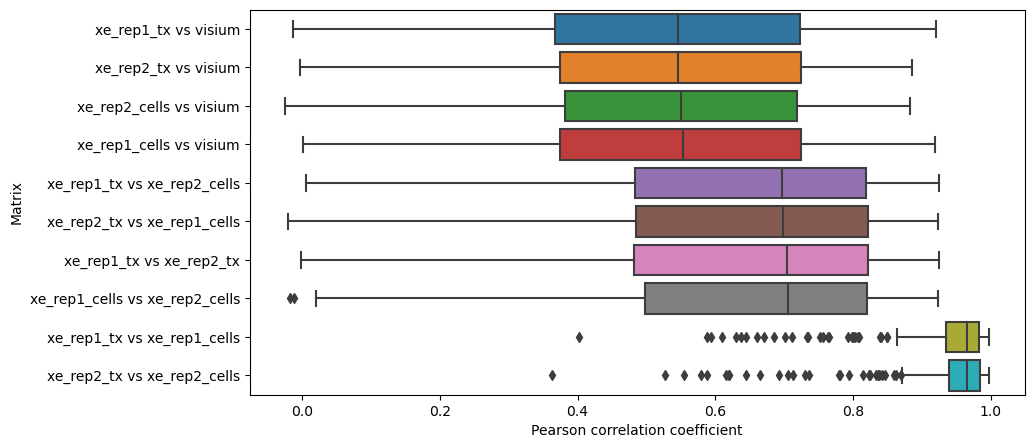

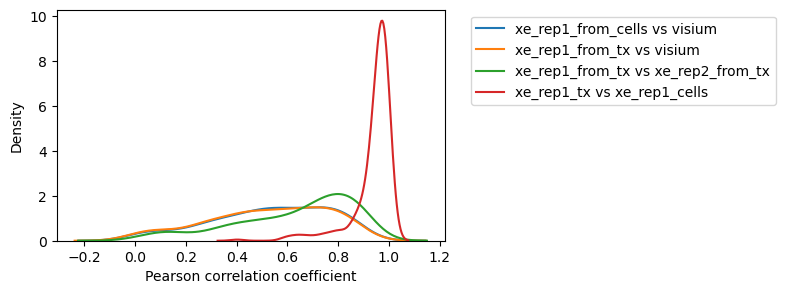

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns


def compute_correlations(X1, X2):
    correlations = []
    # for i in range(X1.shape[0]):
    #     row_correlation1, _ = pearsonr(X1[i], X2[i])
    #     correlations.append(row_correlation1)
    for i in range(X1.shape[1]):
        row_correlation1, _ = pearsonr(X1[:, i], X2[:, i])
        correlations.append(row_correlation1)
    return np.array(correlations)


matrices = {
    "xe_rep1_tx": visium_roi_sdata.table.layers["xe_rep1_tx"],
    "xe_rep2_tx": visium_roi_sdata.table.layers["xe_rep2_tx"],
    "xe_rep1_cells": visium_roi_sdata.table.layers["xe_rep1_cells"],
    "xe_rep2_cells": visium_roi_sdata.table.layers["xe_rep2_cells"],
    "visium": visium_roi_sdata.table.X.toarray(),
}
correlations = {}
for i1, (name1, X1) in enumerate(matrices.items()):
    for i2, (name2, X2) in enumerate(matrices.items()):
        if i1 >= i2:
            continue
        corr = compute_correlations(X1, X2)
        # print(np.sum(np.isnan(corr)))
        correlations[(name1, name2)] = corr

sorted_correlations = dict(
    sorted(correlations.items(), key=lambda x: np.nanmedian(x[1]))
)
print([np.median(x[1]) for x in correlations.items()])


def plot_correlations_seaborn_boxplot(correlations):
    df = pd.DataFrame(
        np.stack(list(correlations.values())),
        index=[" vs ".join(k) for k in correlations.keys()],
    ).T
    df = df.melt(var_name="Matrix", value_name="Pearson correlation coefficient")

    plt.figure(figsize=(10, 5))
    sns.boxplot(
        x="Pearson correlation coefficient",
        y="Matrix",
        data=df,
        # scale="width",
    )
    plt.show()


plot_correlations_seaborn_boxplot(sorted_correlations)


def plot_correlations_seaborn_densities(correlations):
    df = pd.DataFrame(
        np.stack(list(correlations.values())),
        index=[" vs ".join(k) for k in correlations.keys()],
    ).T
    df = df.melt(var_name="Matrix", value_name="Pearson correlation coefficient")

    plt.figure(figsize=(5, 3))
    for matrix_pair in df["Matrix"].unique():
        sns.kdeplot(
            x=df.loc[df["Matrix"] == matrix_pair, "Pearson correlation coefficient"],
            label=matrix_pair,
            common_norm=False,
            common_grid=True,
            lw=1.5,
        )
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()


plot_correlations_seaborn_densities(
    {
        k: sorted_correlations[(k[0].replace("from_", ""), k[1].replace("from_", ""))]
        for k in [
            ("xe_rep1_from_cells", "visium"),
            ("xe_rep1_from_tx", "visium"),
            ("xe_rep1_from_tx", "xe_rep2_from_tx"),
            # ("xe_rep1_cells", "xe_rep2_cells"),
            ("xe_rep1_tx", "xe_rep1_cells"),
        ]
    }
)

In [19]:
# gene case
corr_last = sorted_correlations[("xe_rep2_tx", "xe_rep2_cells")]
corr_second_last = sorted_correlations[("xe_rep1_tx", "xe_rep1_cells")]


# bad_genes = visium_roi_sdata.table.var_names[np.where(corr_last > 0.995)[0]].tolist()
# bad_genes2 = visium_roi_sdata.table.var_names[
#     np.where(corr_second_last > 0.995)[0]
# ].tolist()

bad_genes = visium_roi_sdata.table.var_names[np.where(corr_last < 0.6)[0]].tolist()
bad_genes2 = visium_roi_sdata.table.var_names[
    np.where(corr_second_last < 0.6)[0]
].tolist()
print(len(bad_genes))
print(len(bad_genes2))

5
3


In [42]:
bad_genes

['MUC6', 'AHSP', 'MPO', 'GZMK', 'CRHBP']

In [20]:
print(set(bad_genes).intersection(set(bad_genes2)))

{'GZMK', 'CRHBP', 'MPO'}


second last row


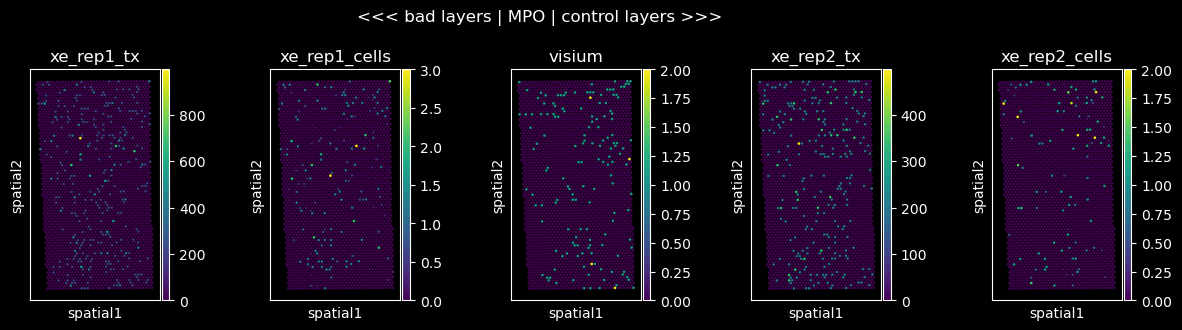

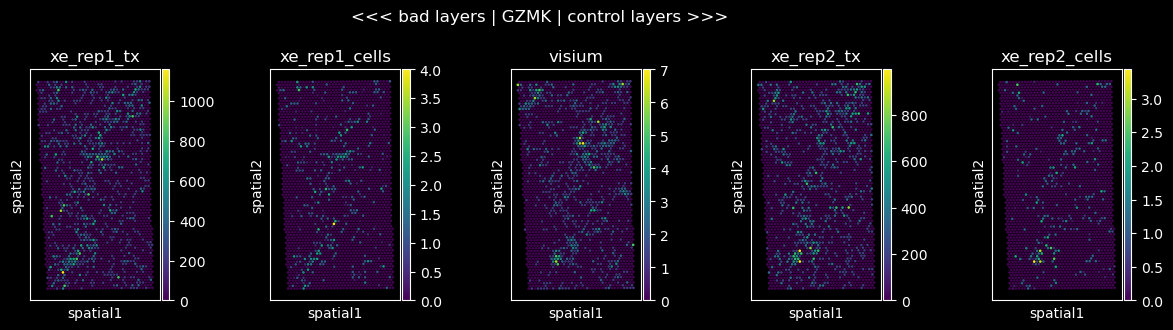

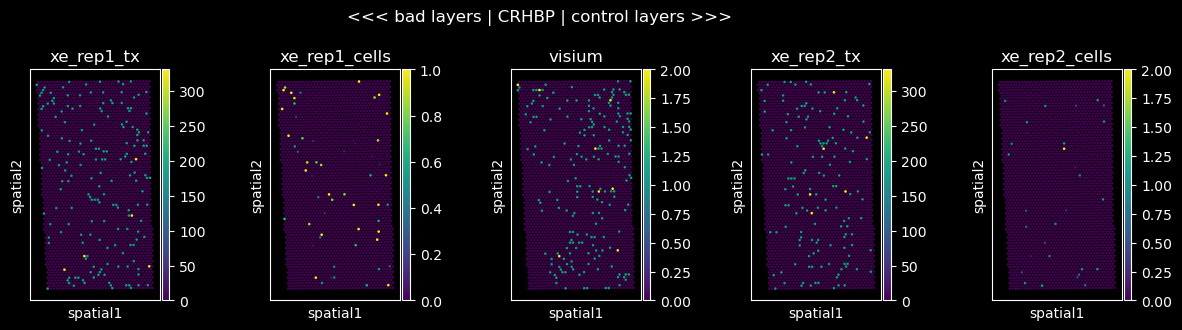

last row


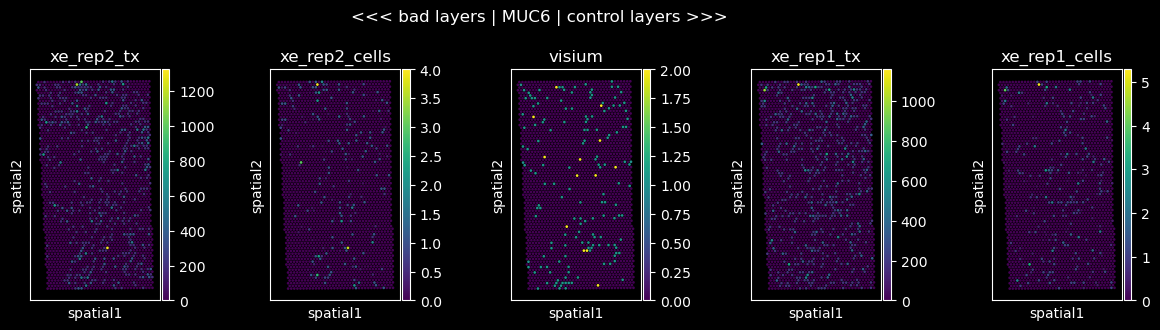

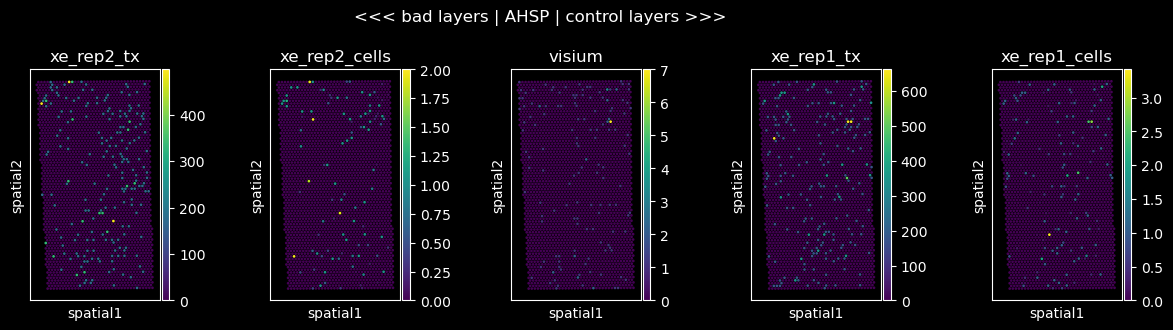

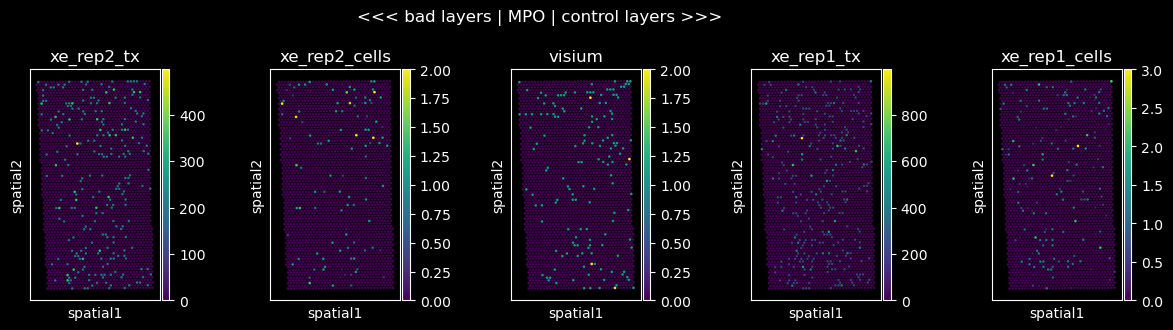

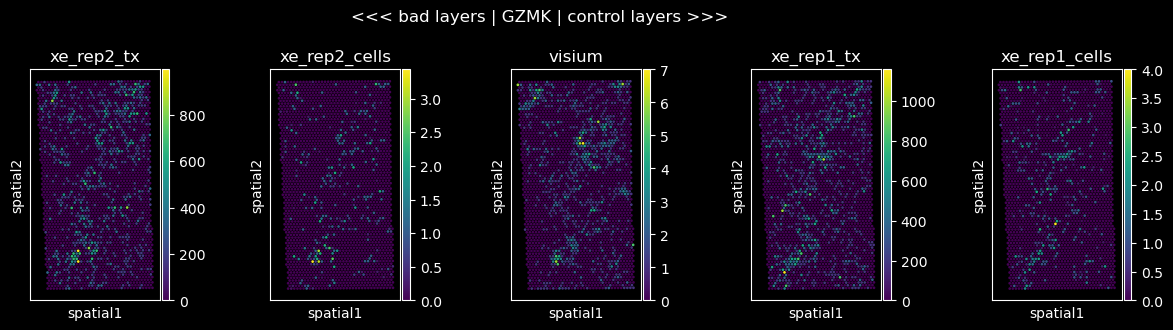

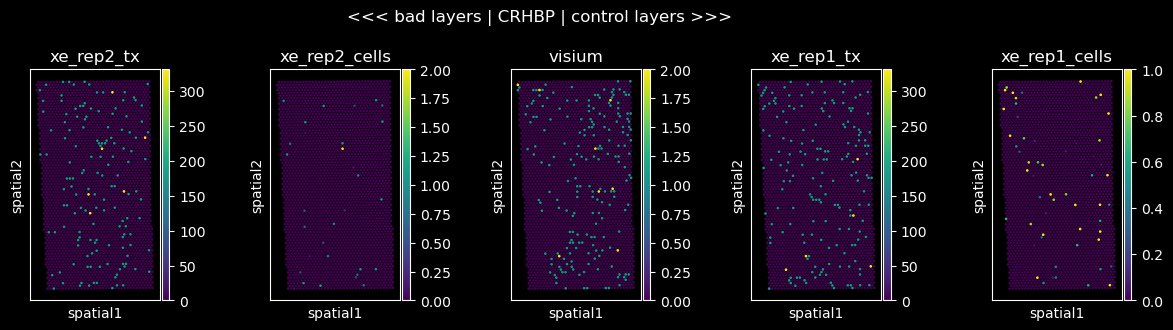

In [21]:
import scanpy as sc
import matplotlib.pyplot as plt

plt.style.use("dark_background")

visium_roi_sdata.table.layers["visium"] = visium_roi_sdata.table.X
for rep in ["rep1", "rep2"]:
    layers = [
        "xe_rep1_tx",
        "xe_rep1_cells",
        "xe_rep2_tx",
        "xe_rep2_cells",
        "visium",
    ]
    if rep == "rep1":
        genes = bad_genes2
        print("second last row")
    else:
        genes = bad_genes
        print("last row")
    bad_layers = [la for la in layers if rep in la] + ["visium"]
    control_layers = [la for la in layers if la not in bad_layers]

    for gene in genes:
        axes = plt.subplots(1, 5, figsize=(15, 3))[1].flatten()
        for i, ax in enumerate(axes):
            layer = (bad_layers + control_layers)[i]
            sc.pl.spatial(
                visium_roi_sdata.table,
                img_key=None,
                library_id=None,
                spot_size=160,
                color=gene,
                layer=layer,
                show=False,
                ax=ax,
                title=layer,
            )
        plt.suptitle(f"<<< bad layers | {gene} | control layers >>>", y=1.08)
    plt.show()

plt.style.use("default")

In [22]:
# custom_gene = "FOXA1"
custom_gene = "GZMK"
gene_index = visium_roi_sdata.table.var_names.tolist().index(custom_gene)
print(gene_index)

v = {}
for layer in ["xe_rep2_tx", "xe_rep2_cells", "visium", "xe_rep1_tx", "xe_rep1_cells"]:
    v[layer] = visium_roi_sdata.table.layers[layer][:, gene_index]

v["visium"] = v["visium"].toarray().flatten()

259


In [23]:
for l0 in v.keys():
    for l1 in v.keys():
        if l0 == l1:
            break
        corr, _ = pearsonr(v[l0], v[l1])
        print(f"{l0} vs {l1}: {corr}")

xe_rep2_cells vs xe_rep2_tx: 0.5542614474089563
visium vs xe_rep2_tx: 0.21820823984647825
visium vs xe_rep2_cells: 0.18337021469183745
xe_rep1_tx vs xe_rep2_tx: 0.19590010500374394
xe_rep1_tx vs xe_rep2_cells: 0.1764507897619288
xe_rep1_tx vs visium: 0.2158483219010539
xe_rep1_cells vs xe_rep2_tx: 0.14546768544480865
xe_rep1_cells vs xe_rep2_cells: 0.1855508687153919
xe_rep1_cells vs visium: 0.1839168136316367
xe_rep1_cells vs xe_rep1_tx: 0.5942996537854692


In [24]:
spatial = np.array(
    [
        visium_roi_sdata["CytAssist_FFPE_Human_Breast_Cancer"].geometry.x,
        visium_roi_sdata["CytAssist_FFPE_Human_Breast_Cancer"].geometry.y,
    ]
).T
visium_roi_sdata.table.obsm["spatial"] = spatial

In [25]:
boundary = visium_roi_sdata[
    "CytAssist_FFPE_Human_Breast_Cancer"
].unary_union.convex_hull

In [40]:
x, y = boundary.exterior.xy

xe_rep1_tx


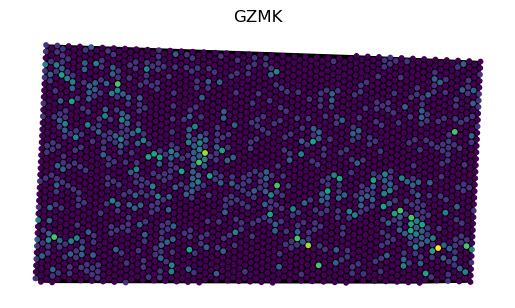

xe_rep1_cells


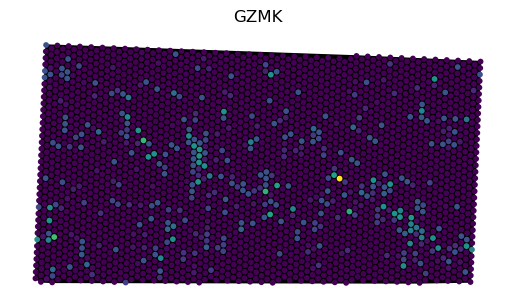

visium


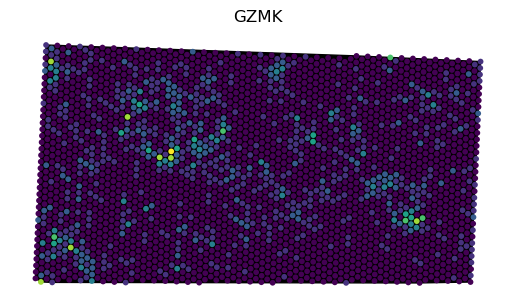

In [41]:
# flipped_table = visium_roi_sdata.table.copy()
# flipped_table.obsm["spatial"] = np.fliplr(flipped_table.obsm["spatial"])
# plt.style.use("dark_background")
for layer in ["xe_rep1_tx", "xe_rep1_cells", "visium"]:
    print(layer)
    ax = plt.gca()
    ax.fill(x, y, c="k")
    sc.pl.spatial(
        # flipped_table,
        visium_roi_sdata.table,
        # transformed_visium.table,
        img_key=None,
        library_id=None,
        spot_size=420,
        color=custom_gene,
        layer=layer,
        frameon=False,
        show=False,
        colorbar_loc=None,
        ax=ax,
    )
    x, y = boundary.exterior.xy
    # ax.invert_yaxis()
    # plt.colorbar(mappable, orientation='horizontal')
    plt.show()
# plt.style.use("default")